In [1]:
%matplotlib widget

In [253]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from astropy.timeseries import BoxLeastSquares, LombScargle

In [197]:
DATADIR = "data"
LCFILE = os.path.join(DATADIR, "plasticc_train_lightcurves.csv.gz")
LCS = pd.read_csv(LCFILE).set_index(["object_id"])

METAFILE = os.path.join(DATADIR, "plasticc_train_metadata.csv.gz")
META = pd.read_csv(METAFILE).set_index(["object_id"])

GPFile = os.path.join(DATADIR, "gp_training_data.csv")
GPS = pd.read_csv(GPFile).set_index(["object_id"])

# source class id mapping
TARGET_MAP = {
    90: "SN1a",
    67: "SN1a-91bg",
    52: "SN1ax",
    42: "SN2",
    62: "SN1bc",
    95: "SLSN1",
    15: "TDE",
    64: "KN",
    88: "AGN",
    92: "RRL",
    65: "M-dwarf",
    16: "EB",
    53: "Mira",
    6: "Microlens",
}
TARGETS = pd.DataFrame.from_dict(TARGET_MAP, columns=["id"], orient="index")

70272 88 AGN


Text(0.5, 0, 'mjd')

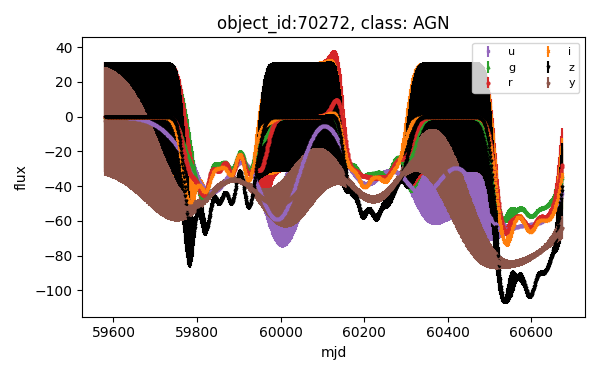

In [237]:
target_id = 88
obj_ids = pd.unique(META[META["target"] == target_id].index)
obj_id = np.random.choice(obj_ids)
target_name = TARGET_MAP[int(META.loc(axis=0)[obj_id].target)]
print(obj_id, target_id, target_name)

num = 1
plt.close(num)
fig, ax = plt.subplots(num=num, figsize=(6,6./1.6), tight_layout=True)
band_colors = ['C4', 'C2', 'C3','C1', 'k', 'C5']    
band_names = ['u','g','r','i','z','y']
band_marker = ['s','^','o','x','v','p']
for band, group in GPS.loc[obj_id].groupby("passband"): #3910
    ax.errorbar(
        x=group["mjd"],
        y=group["flux"],
        yerr=group["flux_err"],
        color=band_colors[band],
        label=band_names[band],
        marker=band_marker[band],
        ms=2,
        ls="",
    )
ax.set_title(f"object_id:{obj_id}, class: {target_name}")
ax.legend(ncol=2, fontsize=8)
ax.set_ylabel("flux")
ax.set_xlabel("mjd")

In [238]:
# multi-color light curve
lc_full = LCS.loc[obj_id]

# filter
passband = 2

# single-color light curve
lc = lc_full.query("passband == @passband")

# BLS Periodogram
minp = 1.
#maxp = (lc.mjd.values[-1] - lc.mjd.values[0]) / 2
maxp = 600
resolution = 200000
duration = 0.5

mode = "custom"

period_values = np.logspace(np.log10(minp), np.log10(maxp), resolution)
period_values = period_values[
    (period_values > duration) & (period_values < maxp)
]

model = BoxLeastSquares(t=lc.mjd, y=lc.flux, dy=lc.flux_err)
period_values_auto = model.autoperiod(
    duration,
    minimum_period=minp,
    maximum_period=maxp,
    frequency_factor=500
)
print(period_values.min(), period_values.max(), period_values_auto.min(), period_values_auto.max())

#result = model.power(period_values_auto, duration)
result = model.autopower(duration)
loc = np.argmax(result.power)
best_period = result.period[loc]
best_t0 = result.transit_time[loc]
print(best_period, best_t0)

1.0 599.9999999999997 1.0 588.4713045549123
1.0008704549129148 59798.41962954509


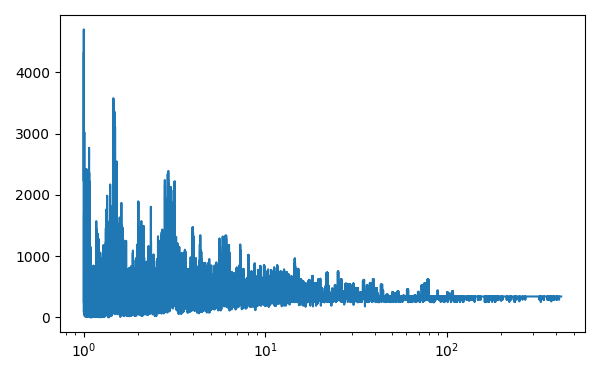

In [239]:
num = 2
plt.close(num)
fig, ax = plt.subplots(num=num, figsize=(6,6./1.6), tight_layout=True)
ax.plot(result.period, result.power)
ax.set_xscale("log")

In [240]:
stats = model.compute_stats(best_period, duration, best_t0)

In [241]:
frequency, power = LombScargle(t=lc.mjd, y=lc.flux, dy=lc.flux_err).autopower()
1. / frequency[np.argmax(power)]  

1219.7262857142882

In [263]:
dd_periods = dict.fromkeys(TARGETS.index.to_list())

for target_id in TARGETS.index.to_list():
    obj_ids = pd.unique(META[META["target"] == target_id].index)
    
    periods = list()
    for i in range(30):
        obj_id = np.random.choice(obj_ids)
        target_name = TARGET_MAP[int(META.loc(axis=0)[obj_id].target)]
        
        
        # multi-color light curve
        lc_full = LCS.loc[obj_id]

        # filter
        passband = 2

        # single-color light curve
        lc = lc_full.query("passband == @passband")
        
        # get periodicity
        frequency, power = LombScargle(t=lc.mjd, y=lc.flux, dy=lc.flux_err).autopower()
        max_p = 1. / frequency[np.argmax(power)]
        
        # save & print 
        periods.append(max_p)
        #print(obj_id, target_id, target_name, max_p)
    
    periods = np.asarray(periods)
    statistics = {
        "mean_": periods.mean(),
        "std_": periods.std(),
        "median_": np.median(periods),
        "mad_": stats.median_abs_deviation(periods),
    }
    dd_periods[target_id] = statistics


In [264]:
df_periods = pd.DataFrame.from_dict(dd_periods).T
df_periods

,mean_,std_,median_,mad_
90,1381.450278,2728.954532,382.232833,306.760515
67,1328.362651,2613.549166,392.965548,211.099743
52,1802.869542,3122.084084,413.637921,211.188233
42,1335.513063,2359.040148,524.558379,248.869188
62,778.928554,1898.020714,317.881074,203.801272
95,1900.659107,2954.830567,648.320231,270.200151
15,1333.389865,2756.151379,328.066852,220.378018
64,149.178742,196.416467,40.537406,22.766547
88,1915.724931,2642.557438,848.739333,545.250956
92,39.567278,38.028939,23.768344,9.017232


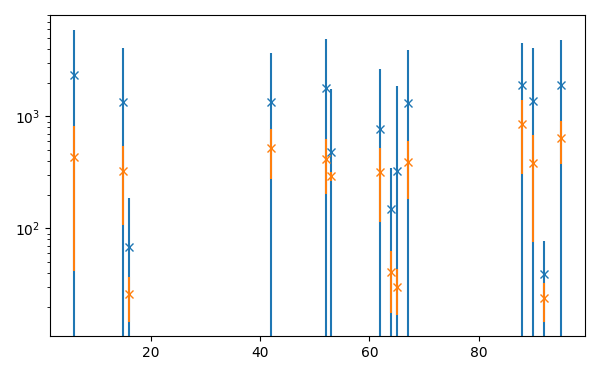

In [269]:
num = 2
plt.close(num)
fig, ax = plt.subplots(num=num, figsize=(6,6./1.6), tight_layout=True)

ax.errorbar(
    TARGETS.index.to_list(),
    df_periods.mean_.values,
    yerr=df_periods.std_.values,
    ls="",
    marker="x",
)
ax.errorbar(
    TARGETS.index.to_list(),
    df_periods.median_.values,
    yerr=df_periods.mad_.values,
    ls="",
    marker="x",
)
ax.set_yscale("log")